## Segmentation

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
import torch
from torch import nn, optim
from torch.nn import functional as F
import torchvision
from torchvision.datasets import VOCSegmentation
from torchvision import transforms
from torch.utils.data import DataLoader

### Unet

In [2]:
class UNet(nn.Module):

  def __init__(self, in_ch, num_classes, transposed=True):
    super().__init__()

    self.dconv_down1 = self._double_conv(in_ch, 64)
    self.dconv_down2 = self._double_conv(64, 128)
    self.dconv_down3 = self._double_conv(128, 256)
    self.dconv_down4 = self._double_conv(256, 512)
    self.dconv_down5 = self._double_conv(512, 1024)

    self.maxpool = nn.MaxPool2d(2)

    self.upconv4 = self._up_conv(1024, 512, transposed=transposed)
    self.upconv3 = self._up_conv(512, 256, transposed=transposed)
    self.upconv2 = self._up_conv(256, 128, transposed=transposed)
    self.upconv1 = self._up_conv(128, 64, transposed=transposed)

    self.dconv_up4 = self._double_conv(1024, 512)
    self.dconv_up3 = self._double_conv(512, 256)
    self.dconv_up2 = self._double_conv(256, 128)
    self.dconv_up1 = self._double_conv(128, 64)

    self.conv_last = nn.Conv2d(64, num_classes, 1)


  def _double_conv(self, in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_ch, out_ch, 3, padding=1),
        nn.ReLU(),
    )

  def _up_conv(self, in_ch, out_ch, transposed=True):
    if transposed:
      return nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
    else:
      return nn.Sequential(
          nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
          nn.Conv2d(in_ch, out_ch, 1))


  def forward(self, X):
    conv1 = self.dconv_down1(X)
    X = self.maxpool(conv1)

    conv2 = self.dconv_down2(X)
    X = self.maxpool(conv2)

    conv3 = self.dconv_down3(X)
    X = self.maxpool(conv3)

    conv4 = self.dconv_down4(X)
    X = self.maxpool(conv4)

    X = self.dconv_down5(X)

    X = self.upconv4(X)
    X = self.dconv_up4(torch.cat([X, conv4], dim=1))
    X = self.upconv3(X)
    X = self.dconv_up3(torch.cat([X, conv3], dim=1))
    X = self.upconv2(X)
    X = self.dconv_up2(torch.cat([X, conv2], dim=1))
    X = self.upconv1(X)
    X = self.dconv_up1(torch.cat([X, conv1], dim=1))

    out = self.conv_last(X)

    return out

In [3]:
# 入力サイズは2^nを想定
X = torch.randn(1, 3, 256, 256)
model = UNet(3, 10, transposed=False)
output = model(X)
output.shape

torch.Size([1, 10, 256, 256])

### PASCAL VOCデータ

In [4]:
def mask_to_tensor(mask):
  return (transforms.ToTensor()(mask) * 255).long()

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    mask_to_tensor,
])
trainset = VOCSegmentation(root='./voc_data', year='2012', image_set='train', download=True, transform=transform, target_transform=target_transform)
valset = VOCSegmentation(root='./voc_data', year='2012', image_set='val', download=True, transform=transform, target_transform=target_transform)

100%|██████████| 1999639040/1999639040 [00:16<00:00, 121581522.37it/s]


Extracting ./voc_data/VOCtrainval_11-May-2012.tar to ./voc_data
Using downloaded and verified file: ./voc_data/VOCtrainval_11-May-2012.tar
Extracting ./voc_data/VOCtrainval_11-May-2012.tar to ./voc_data


In [5]:
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
valloader = DataLoader(valset, batch_size=32)

In [6]:
image, mask = trainset[0]
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_denormalized = image.numpy() * std[:, None, None] + mean[:, None, None]
image_clipped = np.clip(image_denormalized, 0, 1)
image_rescaled = (image_clipped * 255).astype(np.uint8)

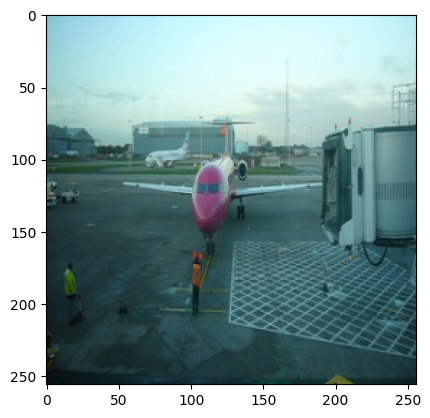

In [7]:
plt.imshow(image_rescaled.transpose(1, 2, 0))

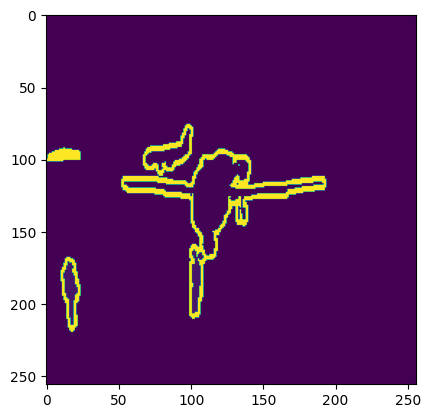

In [8]:
# 0~255の256段階なので，普通に画像を表示するだけだとあまりマスクの色に違いがみれない
plt.imshow(mask.permute(1, 2, 0))

In [ ]:
colored_mask = color.label2rgb(mask[0].numpy(), image_rescaled.transpose(1, 2, 0))
plt.imshow(colored_mask)

### 2クラス分類のデータセットを作る

In [9]:
# 21クラス分類だと学習に時間がかかるため，ここではシンプルな2クラス分類(person vs 背景)にする
class CustomVOCSegmentation(VOCSegmentation):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.person_class_id = 15
        self.data, self.targets = self.filter_dataset()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index]
        mask = self.targets[index]
        return img, mask

    def filter_dataset(self):
        new_data = []
        new_targets = []
        for i in range(super().__len__()):
            img, mask = super().__getitem__(i)
            mask = (mask == self.person_class_id).long()
            if torch.sum(mask) > 0:
                new_data.append(img)
                new_targets.append(mask)
        return new_data, new_targets

# Data Augmetnationを含む前処理
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(256, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(256, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10, fill=(0,)), # 余白は背景とする (255をセットし，損失関数でignore_index=255にするのでもOK)
    mask_to_tensor,
    transforms.Lambda(lambda x: x.squeeze(0)) # DataLoaderから取得する時点で[b, 1, h, w]ではなく[b, h, w]にする (train loopで処理してもよい)
])

# validationではdata augmentaitonをしないので，別途用意
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    mask_to_tensor,
    transforms.Lambda(lambda x: x.squeeze(0))
])
trainset_person = CustomVOCSegmentation(root='./voc_data', year='2012', image_set='train', download=True, transform=train_transform, target_transform=train_target_transform)
valset_person = CustomVOCSegmentation(root='./voc_data', year='2012', image_set='val', download=True, transform=val_transform, target_transform=val_target_transform)
trainloader = DataLoader(trainset_person, batch_size=4, shuffle=True, num_workers=4) # 有料版では複数のスレッドを使用可能
valloader = DataLoader(valset_person, batch_size=4, num_workers=4)

Using downloaded and verified file: ./voc_data/VOCtrainval_11-May-2012.tar
Extracting ./voc_data/VOCtrainval_11-May-2012.tar to ./voc_data
Using downloaded and verified file: ./voc_data/VOCtrainval_11-May-2012.tar
Extracting ./voc_data/VOCtrainval_11-May-2012.tar to ./voc_data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### クラスの重み計算

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# クラスの重みつけ計算
num_classes = 2
class_sample_counts = torch.zeros(num_classes, dtype=torch.int64)
for _, masks in trainloader:
    for mask in masks:
        mask = mask[mask != 255] # すでにDatasetのWrapperクラスで対処ずみだが，21クラス分類にする場合は必要
        class_sample_counts += torch.bincount(mask.flatten(), minlength=num_classes)
class_sample_counts = class_sample_counts.float() + 1e-5
# クラスの出現頻度の逆数を重みにする
class_weights = 1. / class_sample_counts
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)

### モデル，Optimizer, 損失関数定義

In [11]:
model = UNet(in_ch=3, num_classes=num_classes)
model = model.to(device)
opt = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss(ignore_index=255, weight=class_weights) # すでにDatasetのWrapperクラスで対処ずみだが，21クラス分類にする場合はignoreする必要がある

### 学習ループ

In [13]:
num_epochs = 20
save_interval = 10  # 10エポック毎にモデルを評価/保存

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(trainloader, total=len(trainloader), desc="Training", leave=False):
        images = images.to(device)
        masks = masks.to(device)
        # lossが(b, h, w)しか受け付けない -> transformでtransforms.Lambda(lambda x: x.squeeze(0))を実施していれば不要
        # masks = masks.squeeze(1)
        opt.zero_grad()

        outputs = model(images)
        loss = loss_func(outputs, masks)
        loss.backward()
        opt.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(trainloader):.4f}')

    # 各10エポック毎にモデルの評価
    if (epoch + 1) % save_interval == 0:
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, masks in valloader:
                images = images.to(device)
                masks = masks.to(device)
                # masks = masks.squeeze(1)

                outputs = model(images)
                loss = loss_func(outputs, masks)

                val_loss += loss.item()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss / len(valloader):.4f}')

        # モデルの保存
        torch.save(model.state_dict(), f'unet_epoch_{epoch+1}.pth')

Epoch [1/20], Training Loss: 0.5380


Epoch [2/20], Training Loss: 0.5230


Epoch [3/20], Training Loss: 0.5263


Epoch [4/20], Training Loss: 0.5155


Epoch [5/20], Training Loss: 0.5140


Epoch [6/20], Training Loss: 0.5039


Epoch [7/20], Training Loss: 0.4995


Epoch [8/20], Training Loss: 0.4881


Epoch [9/20], Training Loss: 0.4767


Epoch [10/20], Training Loss: 0.4782


Epoch [10/20], Validation Loss: 0.5608


Epoch [11/20], Training Loss: 0.4816


Epoch [12/20], Training Loss: 0.4574


Epoch [13/20], Training Loss: 0.4509


Epoch [14/20], Training Loss: 0.4390


Epoch [15/20], Training Loss: 0.4360


Epoch [16/20], Training Loss: 0.4250


Epoch [17/20], Training Loss: 0.4176


Epoch [18/20], Training Loss: 0.3922


Epoch [19/20], Training Loss: 0.3899


Epoch [20/20], Training Loss: 0.3693
Epoch [20/20], Validation Loss: 0.5144


### モデルの予測結果可視化

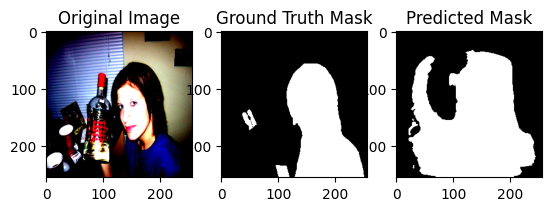

In [14]:
# モデルの予測結果の描画
model.eval()
with torch.no_grad():
    images, masks = next(iter(valloader))
    images = images.to(device)
    masks = masks.to(device)
    outputs = model(images)
    # ひとまず最も値が大きいクラスを出力とするが，実際にはアプリケーションに応じて閾値を決める
    _, predicted_masks = torch.max(outputs, 1)

    # TensorをGPUからCPUに移動する
    images = images.cpu()
    predicted_masks = predicted_masks.cpu()
    masks = masks.cpu()

    index = 2

    image = images[index].permute(1, 2, 0)
    predicted_mask = predicted_masks[index]
    mask = masks[index]

    # Tensor -> Numpy Array
    image = image.numpy()
    predicted_mask = predicted_mask.numpy()
    mask = mask.numpy()

    fig, ax = plt.subplots(1, 3)

    # Plot image
    ax[0].imshow(image)
    ax[0].title.set_text('Original Image')

     # Plot mask
    ax[1].imshow(mask, cmap='gray')
    ax[1].title.set_text('Ground Truth Mask')

    # Plot prediction
    ax[2].imshow(predicted_mask, cmap='gray')
    ax[2].title.set_text('Predicted Mask')

    plt.show()

### モデルの出力を可視化

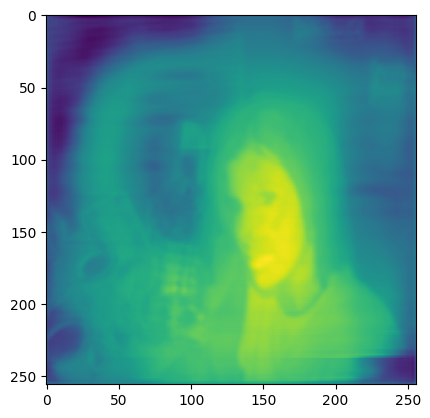

In [15]:
pred_map = outputs[index, 1, :, :]
plt.imshow(pred_map.cpu())